In [51]:
import numpy as np
import pandas as pd
from xgboost import XGBClassifier
import xgboost
from catboost import CatBoostClassifier
import lightgbm as lgbm

from sklearn.model_selection import StratifiedKFold
from sklearn.model_selection import cross_val_score
from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix
from sklearn.metrics import make_scorer, fbeta_score
from sklearn.metrics import roc_auc_score
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import FunctionTransformer
from sklearn.ensemble import VotingClassifier

import seaborn as sns
sns.set_context("talk")

import joblib
import time
import matplotlib.pyplot as plt
from datetime import date
from sklearn.metrics import accuracy_score

In [52]:
df = pd.read_csv("../data/junio12.csv",encoding = "ISO-8859-1")
df["FECHA_SINTOMAS"] = pd.to_datetime(df["FECHA_SINTOMAS"], errors="coerce")
df["FECHA_DEF"] = pd.to_datetime(df["FECHA_DEF"], errors="coerce")
df["FECHA_INGRESO"] = pd.to_datetime(df["FECHA_INGRESO"], errors="coerce")
today = date.today()
today

datetime.date(2020, 6, 12)

In [53]:
df_positivos = df[df["RESULTADO"] == 1]

In [54]:
corte = 15
df_positivos["anterior_corte"] = (pd.to_datetime(today) - df_positivos["FECHA_SINTOMAS"]).dt.days > corte
df_creibles = df_positivos[(df_positivos["FECHA_DEF"].notnull()) | (df_positivos["anterior_corte"])]
df_creibles.drop("anterior_corte", axis=1, inplace=True)
df_creibles["fallecio"] = df_creibles["FECHA_DEF"].notna()
df_creibles["fallecio"] = df_creibles["fallecio"].astype(int)

df_creibles = df_creibles.drop(["FECHA_ACTUALIZACION", 
              "ID_REGISTRO", 
              'FECHA_INGRESO', 
              'FECHA_SINTOMAS',
              'FECHA_DEF',
              'ORIGEN',
              'SECTOR',
              'ENTIDAD_UM',
              'ENTIDAD_NAC',
              'ENTIDAD_RES',
              'MUNICIPIO_RES',
              'TIPO_PACIENTE',
              'NACIONALIDAD',
              'HABLA_LENGUA_INDIG',
              'RESULTADO',
              'MIGRANTE',
              'PAIS_NACIONALIDAD',
              'PAIS_ORIGEN',
              'INTUBADO',
              'UCI',
              'OTRO_CASO'], axis=1)

# df_creibles.head()
# df["fallecio"].value_counts()

<ipython-input-54-200fc78e4f08>:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_positivos["anterior_corte"] = (pd.to_datetime(today) - df_positivos["FECHA_SINTOMAS"]).dt.days > corte
/home/davinchi/Documents/covid19/tarea 5/venv/lib/python3.8/site-packages/pandas/core/frame.py:3990: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  return super().drop(
<ipython-input-54-200fc78e4f08>:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documen

In [55]:
categoricas = ['SEXO', 'NEUMONIA', 'EMBARAZO', 'DIABETES', 'EPOC',
       'ASMA', 'INMUSUPR', 'HIPERTENSION', 'OTRA_COM', 'CARDIOVASCULAR',
       'OBESIDAD', 'RENAL_CRONICA', 'TABAQUISMO', 'fallecio']

for col in categoricas:
    df_creibles[col] = df_creibles[col].astype('category')

In [56]:
def plot_cm(y_test, y_pred, normalize=None):
    # values: dict of prediction {"0": "Not fraud", "1":"Fraud"}
    
    cm = np.round(confusion_matrix(y_test, y_pred, normalize=normalize),4)
    
    plt.figure()
    ax = sns.heatmap(cm,annot=True, xticklabels=["No falleció", "falleció"],yticklabels=["No falleció", "falleció"])

    
    ax.set_xlabel("Predicted")
    ax.set_ylabel("Real")
    ax.set_title("Confussion matrix", fontsize = 15)

    plt.show()

In [57]:
def to_float(x):
    return pd.DataFrame(x).astype("float")

In [58]:
def ensemble(models):
    for model in models:
        if type(xgb_clf) == xgboost.sklearn.XGBClassifier:
            model.fit(X_train.astype("float"), y_train)
        else:
            model.fit(X_train, y_train)

In [59]:
X = df_creibles.drop("fallecio", axis=1)
y = df_creibles["fallecio"]

In [60]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = 0.2, random_state =0, stratify=y)
print(X_train.shape)
print(X_test.shape)

(88762, 14)
(22191, 14)


In [68]:
xgb_clf = XGBClassifier(base_score=0.5, booster='gbtree', colsample_bylevel=1,
              colsample_bynode=1, colsample_bytree=0.6, gamma=5.0, gpu_id=-1,
              importance_type='gain', interaction_constraints='',
              learning_rate=0.300000012, max_delta_step=0, max_depth=1,
              min_child_weight=10, monotone_constraints='()',
              n_estimators=79, n_jobs=0, num_parallel_tree=1,
              objective='binary:logistic', random_state=1, reg_alpha=0,
              reg_lambda=1, scale_pos_weight=8.391411686627396, subsample=1.0,
              tree_method='exact', validate_parameters=1, verbosity=None)
xgb_pipe = Pipeline([('type_trans', FunctionTransformer(to_float)), ('xgb', xgb_clf)])

cb_clf = CatBoostClassifier(cat_features=['SEXO', 'NEUMONIA', 'EMBARAZO', 'DIABETES', 'EPOC',
       'ASMA', 'INMUSUPR', 'HIPERTENSION', 'OTRA_COM', 'CARDIOVASCULAR',
       'OBESIDAD', 'RENAL_CRONICA', 'TABAQUISMO'], class_weights = [0.2, 0.8])

lgbm_clf = lgbm.LGBMClassifier(bagging_fraction=0.99, bagging_freq=23, boosting_type='dart',
               class_weight=None, colsample_bytree=1.0, feature_fraction=0.99,
               importance_type='split', is_unbalance=True,
               learning_rate=0.47438311580676384, max_depth=2, metric='auc',
               min_child_samples=20, min_child_weight=7, min_split_gain=0.0,
               n_estimators=100, n_jobs=-1, num_leaves=62, objective='binary',
               random_state=None, reg_alpha=0.99, reg_lambda=0.9, silent=True,
               subsample=1.0, subsample_for_bin=200000, subsample_freq=0,
               verbose_eval=100)

model = VotingClassifier(estimators=[('lgb', lgbm_clf), ('xb', xgb_pipe), ('cb', cb_clf)],
                         voting='soft', 
                         flatten_transform=True,
                         weights=[1,1,1])

In [69]:
model.fit(X_train, y_train)

Learning rate set to 0.069956
0:	learn: 0.6499227	total: 69.9ms	remaining: 1m 9s
1:	learn: 0.6143484	total: 146ms	remaining: 1m 12s
2:	learn: 0.5873552	total: 208ms	remaining: 1m 9s
3:	learn: 0.5614542	total: 289ms	remaining: 1m 11s
4:	learn: 0.5400732	total: 359ms	remaining: 1m 11s
5:	learn: 0.5226565	total: 446ms	remaining: 1m 13s
6:	learn: 0.5084311	total: 520ms	remaining: 1m 13s
7:	learn: 0.4971793	total: 578ms	remaining: 1m 11s
8:	learn: 0.4868673	total: 662ms	remaining: 1m 12s
9:	learn: 0.4772656	total: 744ms	remaining: 1m 13s
10:	learn: 0.4694093	total: 816ms	remaining: 1m 13s
11:	learn: 0.4630420	total: 907ms	remaining: 1m 14s
12:	learn: 0.4574467	total: 983ms	remaining: 1m 14s
13:	learn: 0.4528686	total: 1.06s	remaining: 1m 14s
14:	learn: 0.4492389	total: 1.14s	remaining: 1m 15s
15:	learn: 0.4459428	total: 1.22s	remaining: 1m 14s
16:	learn: 0.4426695	total: 1.28s	remaining: 1m 13s
17:	learn: 0.4398410	total: 1.34s	remaining: 1m 13s
18:	learn: 0.4374637	total: 1.43s	remaining: 

VotingClassifier(estimators=[('lgb',
                              LGBMClassifier(bagging_fraction=0.99,
                                             bagging_freq=23,
                                             boosting_type='dart',
                                             class_weight=None,
                                             colsample_bytree=1.0,
                                             feature_fraction=0.99,
                                             importance_type='split',
                                             is_unbalance=True,
                                             learning_rate=0.47438311580676384,
                                             max_depth=2, metric='auc',
                                             min_child_samples=20,
                                             min_child_weight=7,
                                             min_split_gain=0.0,
                                             n_estimators=100, n_...
               

In [70]:
y_pred = model.predict(X_test)
y_scores = model.predict_proba(X_test)[:,1]

In [71]:
roc_auc_score(y_test, y_scores)

0.8797089702462043

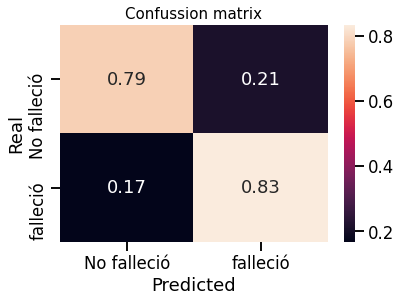

In [72]:
plot_cm(y_test, y_pred, normalize="true")

In [73]:
accuracy_score(y_test, y_pred)

0.7931143256275066